In [5]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
#import io

df = pd.read_csv(r"/content/bbc-text.csv")
print (df)

           category                                               text
0              tech  tv future in the hands of viewers with home th...
1          business  worldcom boss  left books alone  former worldc...
2             sport  tigers wary of farrell  gamble  leicester say ...
3             sport  yeading face newcastle in fa cup premiership s...
4     entertainment  ocean s twelve raids box office ocean s twelve...
...             ...                                                ...
2220       business  cars pull down us retail figures us retail sal...
2221       politics  kilroy unveils immigration policy ex-chatshow ...
2222  entertainment  rem announce new glasgow concert us band rem h...
2223       politics  how political squabbles snowball it s become c...
2224          sport  souness delight at euro progress boss graeme s...

[2225 rows x 2 columns]


In [6]:
vocab_size = 1000          # number of words
embedding_dim = 16         # word dimintion
max_length = 120
turn_type = 'post'
padding_type = 'post'
oov_tok = "OOV"            # out of vocab.. when word didnot exist
training_portion = .8      # to split data 80 to 20 for training

In [7]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [8]:
with open("/content/bbc-text.csv", 'r') as csvfile:
    for line in csvfile:
      entry = line.split(',')
      labels.append(entry[0])
      sentences.append(entry[1])

sentences = sentences[1:]
labels = labels[1:]

print(len(labels))
print(len(sentences))
print(sentences[0])
print(labels[0])

2225
2225
tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-i

In [9]:
train_size = int(training_portion*len(sentences))   # 80%

train_sentences = sentences[0:train_size]
train_labels = labels[0:train_size]

validation_sentences = sentences[train_size:]       # 20%
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [10]:
# tokenizer training set
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# turn tokens into sequence
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# pad training sequence
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=turn_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))


750
120
300
120
311
120


In [11]:
# tokenizer validation set
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=turn_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [12]:
# tokenize labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = label_tokenizer.texts_to_sequences(train_labels)
validation_label_seq = label_tokenizer.texts_to_sequences(validation_labels)

training_label_seq = np.array(training_label_seq)
validation_label_seq = np.array(validation_label_seq)

print("label_tokenizer word index " , label_tokenizer.word_index)
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

label_tokenizer word index  {'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}
[5]
[2]
[1]
(1780, 1)
[4]
[5]
[3]
(445, 1)


In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(24, activation = 'relu'),
  tf.keras.layers.Dense(6 , activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, validation_data=(validation_padded, validation_label_seq), epochs=num_epochs)


Epoch 1/30
56/56 [==============================] - 13s 122ms/step - loss: 1.7609 - accuracy: 0.2461 - val_loss: 1.7233 - val_accuracy: 0.2382
Epoch 2/30
56/56 [==============================] - 4s 69ms/step - loss: 1.6873 - accuracy: 0.3253 - val_loss: 1.6453 - val_accuracy: 0.2742
Epoch 3/30
56/56 [==============================] - 2s 43ms/step - loss: 1.6052 - accuracy: 0.3478 - val_loss: 1.5602 - val_accuracy: 0.4225
Epoch 4/30
56/56 [==============================] - 2s 29ms/step - loss: 1.5029 - accuracy: 0.4573 - val_loss: 1.4465 - val_accuracy: 0.5124
Epoch 5/30
56/56 [==============================] - 1s 23ms/step - loss: 1.3597 - accuracy: 0.5882 - val_loss: 1.2921 - val_accuracy: 0.6360
Epoch 6/30
56/56 [==============================] - 1s 19ms/step - loss: 1.1821 - accuracy: 0.6994 - val_loss: 1.1228 - val_accuracy: 0.7034
Epoch 7/30
56/56 [==============================] - 0s 5ms/step - loss: 0.9938 - accuracy: 0.7635 - val_loss: 0.9496 - val_accuracy: 0.7820
Epoch 8/30
5

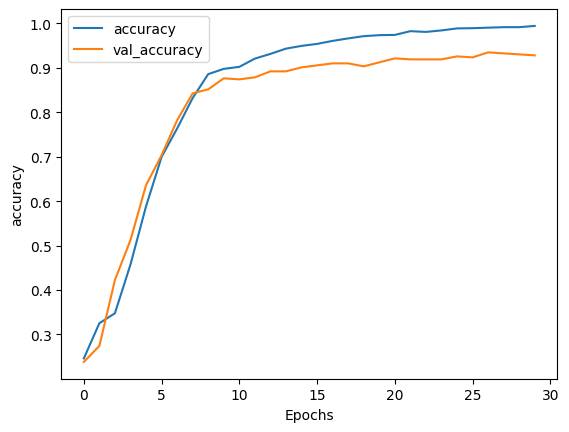

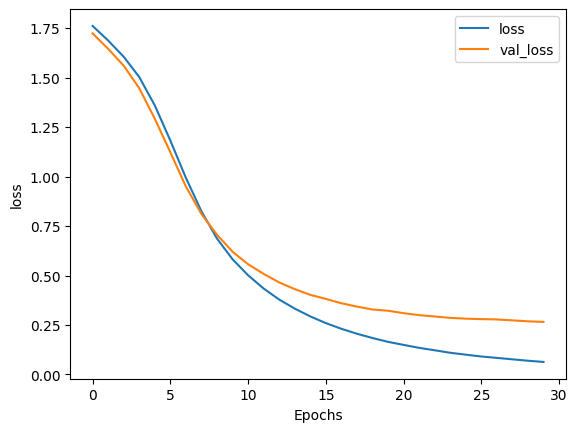

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")